In [1]:
import sys 
import pdb 
from DOA_utils import (generate_ula_data_nonuniform, RootMUSIC1D,
                       non_uniform_Gaussian_CRB, nonuniform_MVT_CRB,
                       plot_spectrum)
import sys
sys.path.append("../../")
from estimators.N_estimators import sample_mean_and_cov_complex, GFA_EM_complex
from estimators.TRex_complex import TRex_complex
from estimators.STE import STE_complex
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
seed = 96
np.random.seed(seed)


In [2]:
# define parameters for the experiment
snr = 5
theta_rad = np.array([0, 5, 10, 15]) * np.pi / 180
num_of_sources, power_source = len(theta_rad), 1
P = power_source * np.eye(num_of_sources)
wavelength = 1
wavelength_factor = 2
d = wavelength / wavelength_factor
num_of_sensors = 15
noise_variances = np.random.rand(num_of_sensors)
scaling = np.sum(1/noise_variances) / (snr * num_of_sensors / power_source)
noise_variances *= scaling 
all_num_of_samples = [50, 75, 100, 125, 150, 175, 200]
MC_runs = 300
all_errors_TRex_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_S_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_GFA_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_TRex_T = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_S_T = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_GFA_T = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_STE_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_STE_T = np.zeros((len(all_num_of_samples), MC_runs))
degrees_of_freedom = 3

In [3]:
RootMusicEstimator = RootMUSIC1D(wavelength)

simulating num_of_samples = 50
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  180
run:  200
run:  220
run:  240
run:  260
run:  280
simulating num_of_samples = 75
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  180
run:  200
run:  220
run:  240
run:  260
run:  280
simulating num_of_samples = 100
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  180
run:  200
run:  220
run:  240
run:  260
run:  280
simulating num_of_samples = 125
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  180
run:  200
run:  220
run:  240
run:  260
run:  280
simulating num_of_samples = 150
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  180
run:  200
run:  220
run:  240
run:  260
run:  280
simulating num_of_samples = 175
run:  0
run:  20
run:  40
run:  60
run:  80
run:  100
run:  120
run:  140
run:  160
run:  

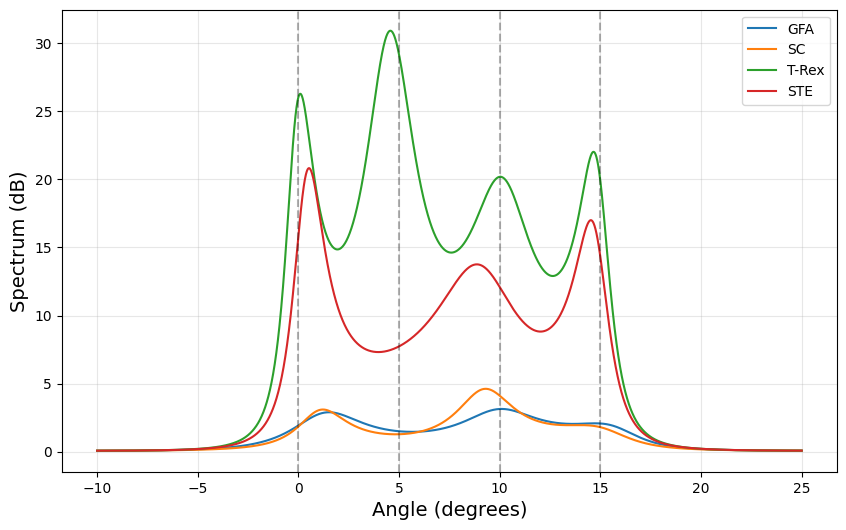

In [4]:
for signal_distribution in ['N', 'T']:
    for ii in range(len(all_num_of_samples)):
        num_of_samples = all_num_of_samples[ii]
        print(f"simulating num_of_samples = {num_of_samples}")
        for run in range(MC_runs):
            if run % 20 == 0:
                print("run: ", run)
            [Y, true_cov, A_true] = generate_ula_data_nonuniform(power_source, 
                                    noise_variances, d, num_of_sensors, 
                                    num_of_sources, num_of_samples, wavelength, 
                                    theta_rad, degrees_of_freedom, signal_distribution)
            X = Y - np.mean(Y, axis=1, keepdims=True)

            # compute covariance estimates
            S_EM = sample_mean_and_cov_complex(X)[1]
            F_G, d_G = GFA_EM_complex(S_EM, num_of_sources, iter=100)
            F_TRex, d_TRex, _ = TRex_complex(X, num_of_sources, outer_max_iter=5,
                                          inner_max_iter=100)
            
            # This choice of STE seems to be good for this task
            cov_STE, _ = STE_complex(X, num_of_sources, 0.8)
            
            # compute DOA:s
            doa_F_TRex = np.flip(-RootMusicEstimator.estimate(F_TRex @ F_TRex.conj().T, num_of_sources, d)[1]._locations)
            doa_F_G = np.flip(-RootMusicEstimator.estimate(F_G @ F_G.conj().T, num_of_sources, d)[1]._locations)
            doa_S = np.flip(-RootMusicEstimator.estimate(S_EM, num_of_sources, d)[1]._locations)
            doa_STE = np.flip(-RootMusicEstimator.estimate(cov_STE, num_of_sources, d)[1]._locations)

            if run == 0 and num_of_samples == 100 and signal_distribution == 'T':
                plot_spectrum([F_G @ F_G.conj().T, S_EM, F_TRex @ F_TRex.conj().T,
                               cov_STE],
                              ['GFA', 'SC', 'T-Rex', 'STE'], num_of_sources, theta_rad, run)


            TRex_error = LA.norm(theta_rad - doa_F_TRex)**2
            GFA_error = LA.norm(theta_rad - doa_F_G)**2
            S_error = LA.norm(theta_rad - doa_S)**2
            STE_error = LA.norm(theta_rad - doa_STE)**2
        
            if signal_distribution == "N":
                all_errors_TRex_N[ii, run] = TRex_error
                all_errors_GFA_N[ii, run] = GFA_error
                all_errors_S_N[ii, run] = S_error
                all_errors_STE_N[ii, run] = STE_error
            else:
                all_errors_TRex_T[ii, run] = TRex_error
                all_errors_GFA_T[ii, run] = GFA_error
                all_errors_S_T[ii, run] = S_error
                all_errors_STE_T[ii, run] = STE_error

In [5]:
# compute CRBs
CRB_N = []
CRB_T = []
for samples in all_num_of_samples:
    CRB_N.append(np.trace(non_uniform_Gaussian_CRB(P, theta_rad, noise_variances,
                                    num_of_sensors, 1 / wavelength_factor, samples)))
    CRB_T.append(np.trace(nonuniform_MVT_CRB(P, theta_rad, np.diag(noise_variances), 
                                             num_of_sensors, samples, 
                                             1 / wavelength_factor, 
                                             degrees_of_freedom)[0]))
CRB_N = np.array(CRB_N)
CRB_T = np.array(CRB_T)

/home/daniel/Documents/Research/code_paper_repos/T-Rex-EM/experiments/DOA/DOA_utils.py:358: ComplexWarning: Casting complex values to real discards the imaginary part
  F_G[row, col] = term2 / psi
/home/daniel/Documents/Research/code_paper_repos/T-Rex-EM/experiments/DOA/DOA_utils.py:360: ComplexWarning: Casting complex values to real discards the imaginary part
  F[row, col] = term1 + term2


In [6]:
MSE_TRex_N = np.mean(all_errors_TRex_N, axis=1)
MSE_GFA_N = np.mean(all_errors_GFA_N, axis=1)
MSE_S_N = np.mean(all_errors_S_N, axis=1)
MSE_TRex_T = np.mean(all_errors_TRex_T, axis=1)
MSE_GFA_T = np.mean(all_errors_GFA_T, axis=1)
MSE_S_T = np.mean(all_errors_S_T, axis=1)
MSE_STE_N = np.mean(all_errors_STE_N, axis=1)
MSE_STE_T = np.mean(all_errors_STE_T, axis=1)

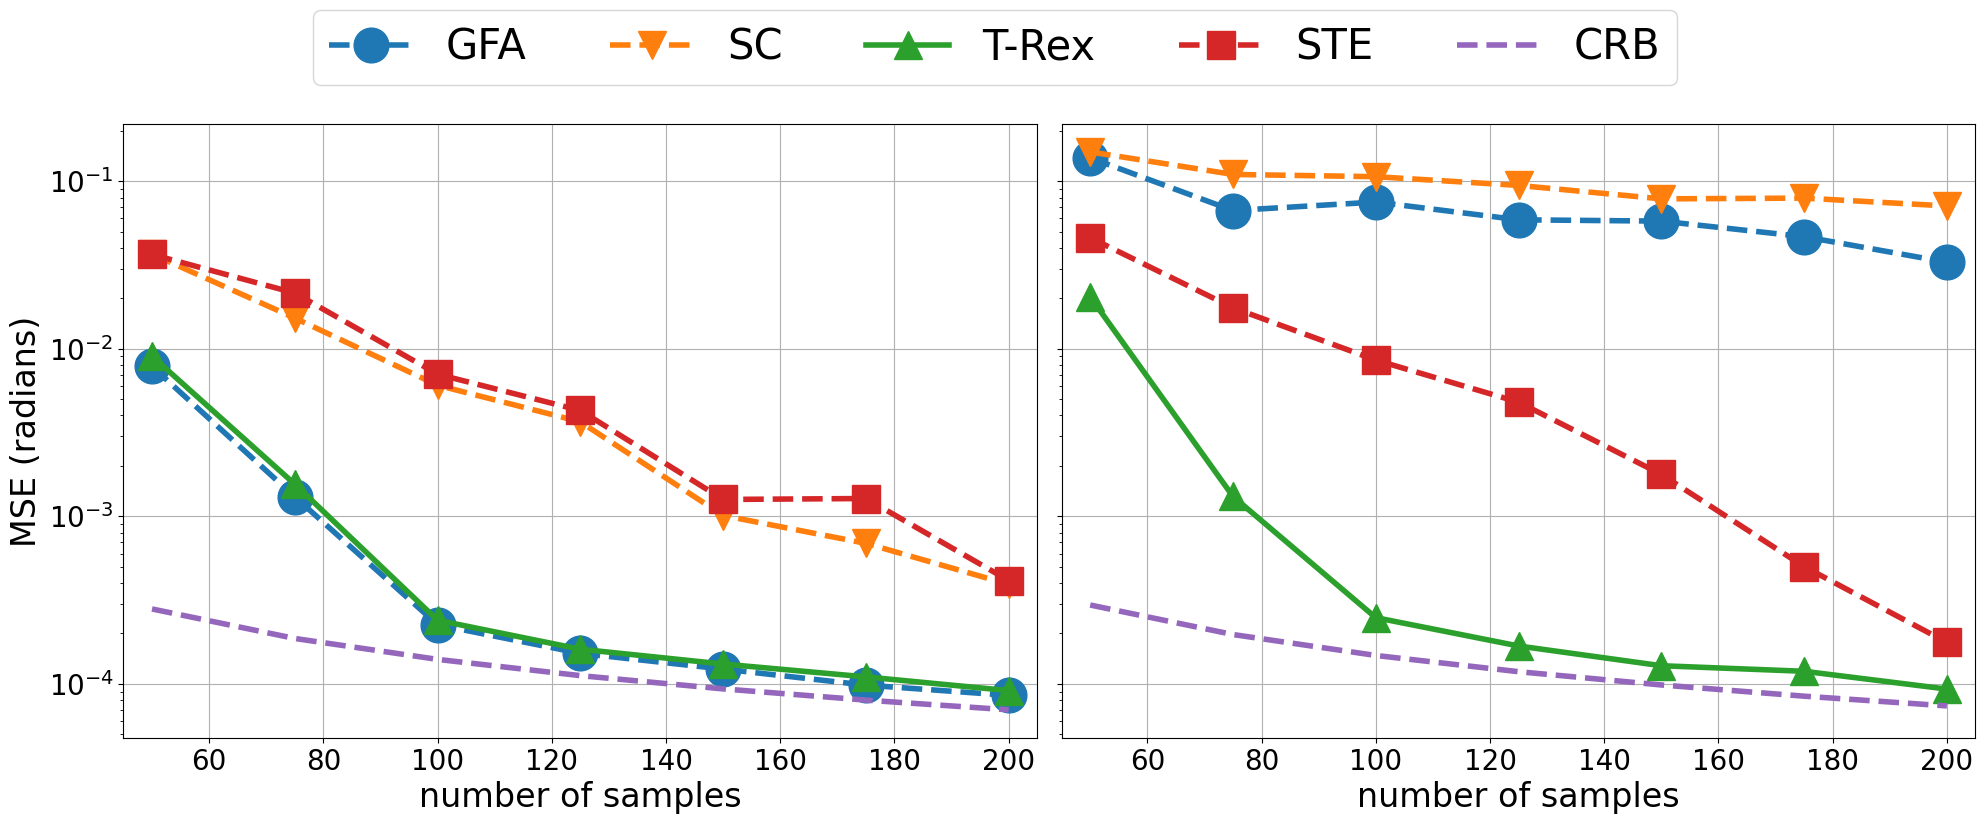

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Store line handles for the legend
legend_handles = []

for i, distribution in enumerate(['N', 'T']):
    ax = axes[i]

    if distribution == "N":
        MSE_TRex = MSE_TRex_N
        MSE_GFA = MSE_GFA_N 
        MSE_S = MSE_S_N 
        MSE_STE = MSE_STE_N
        CRB = CRB_N 
    else:
        MSE_TRex = MSE_TRex_T
        MSE_GFA = MSE_GFA_T
        MSE_S = MSE_S_T
        MSE_STE = MSE_STE_T
        CRB = CRB_T

    # Plot MSEs with markers and error bars
    line1, = ax.semilogy(all_num_of_samples, MSE_GFA, marker='o', linestyle='--', linewidth=4, markersize=25, label='GFA')
    line2, = ax.semilogy(all_num_of_samples, MSE_S, marker='v', linestyle='--', linewidth=4, markersize=20, label='SC')
    line3, = ax.semilogy(all_num_of_samples, MSE_TRex, marker='^', linestyle='-', linewidth=4, markersize=20, label='T-Rex')
    line4, = ax.semilogy(all_num_of_samples, MSE_STE, marker='s', linestyle='--', linewidth=4, markersize=20, label='STE')
    line5, = ax.semilogy(all_num_of_samples, np.real(CRB), linestyle='--', linewidth=4, label='CRB')

    # Save handles only once
    if i == 0:
        legend_handles = [line1, line2, line3, line4, line5]

    ax.set_xlabel('number of samples', fontsize=24)
    if i == 0:
        ax.set_ylabel('MSE (radians)', fontsize=24)

    ax.set_xlim(45, 205)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True)

fig.legend(handles=legend_handles, fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space on top for legend
plt.savefig("DOA_MSE_CRB.pdf", bbox_inches='tight', dpi=300)
plt.show()
